In [1]:
import tensorflow as tf
import numpy as np
import os
import re
import io
import librosa
import pickle
import random
import matplotlib.pyplot as plt
import IPython.display as ipd
from os.path import isdir, join
%matplotlib inline

In [ ]:
# model_name = "VGG11"
model_name =  "LSTM_CTC"

In [2]:
save_dir = "/home/maikfangogoair/tmp/save/"
pkl_file = "spect_v25.pkl"
with open (save_dir + pkl_file, 'rb') as fp:
    all_data = pickle.load(fp)
print("There are total %d data to be trained." % len(all_data))

There are total 97043 data to be trained.


In [3]:
tf.reset_default_graph();
input=tf.placeholder(tf.float32, (None, 99, 161), 'input')
def spectrogram_ConvNet(input):
    """
    """
    dropout_prob = tf.placeholder(tf.float32, name='dropout_prob')
    
    
    reshape_input = tf.reshape(input, [-1, 99, 161, 1], 'reshape_input')
    batch_input = tf.layers.batch_normalization(reshape_input)
    
    conv_1 = tf.layers.conv2d(batch_input, 64, (5,5), (1,1), 'same', name='conv_1')
    relu_1 = tf.nn.relu(conv_1,'relu_1')
    dropout_1 = tf.nn.dropout(relu_1, dropout_prob, name = 'dropout_1')
    
    max_pool = tf.nn.max_pool(dropout_1, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')

    conv_2 = tf.layers.conv2d(max_pool, 64, (3,3), (1,1), 'same')
    relu_2 = tf.nn.relu(conv_2,'relu_2')
    dropout_2 = tf.nn.dropout(relu_2, dropout_prob, name = 'dropout_2')
    
    size=int(dropout_2.get_shape()[1]) * int(dropout_2.get_shape()[2]) * int(dropout_2.get_shape()[3])
    flatten = tf.reshape(dropout_2, (-1, size), 'flatten')

    logits = tf.layers.dense(flatten, class_cnt,name = 'logits')
    
    return logits,dropout_prob

In [4]:
tf.reset_default_graph();
input=tf.placeholder(tf.float32, (None, 1, 161, 101))              
def VGG11(input, class_cnt, verbose):
    """
    This is a 11 layers VGG model.
    inputs:
    - input in shape [batch_size, 1, spectrum/MFCC features, time steps], eg: [None, 1, 161, 101]
    - class_cnt is the final logits class count, this model maybe used for 31 classes and 12 classes training.
    - verbose to control the log level
    outputs:
    - logits in shape [batch_size, class_cnt]
    - dropout_prob retain the placeholder here to reserve the solution for overfitting
    """
    steps = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
    dropout_prob = tf.placeholder(tf.float32, name='dropout_prob')
    features = tf.transpose(input,[0, 2, 3, 1])
    if verbose: print(features)
    for i in range(len(steps)):
        step = steps[i]
        with tf.variable_scope("Layer"+str(i+1), reuse=False):
            if step == 'M':
                features = tf.layers.max_pooling2d(features , (2,2) , (2,2) ,"same")
                if verbose: print(features)
            else:
                features = tf.layers.conv2d(features, step, (3,3), (1,1), 'same', name='conv_1')
                if verbose: print(features)
                features = tf.layers.batch_normalization(features)
                if verbose: print(features)
                features = tf.nn.relu(features)
                if verbose: print(features)
    features = tf.layers.average_pooling2d(features , (1,1), (1,1), 'same')
    if verbose: print(features)
    features = tf.layers.flatten(features)
    if verbose: print(features)
    features = tf.layers.dense(features, 512)
    if verbose: print(features)
    logits = tf.layers.dense(features, class_cnt )
    if verbose: print(features)
    
    return logits,dropout_prob

In [5]:
model_cfg = {"spectrogram_ConvNet": spectrogram_ConvNet, "VGG11": VGG11}
model = model_cfg[model_name]
with io.open(save_dir + "wanted_list.pkl", 'rb') as f:
    wanted_list = pickle.load(f)
print(wanted_list)
class_cnt = len(wanted_list)
print("final class count is : %d ." % class_cnt)
logits,dropout_prob = model(input, class_cnt, False)

['silence', 'unknown', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
final class count is : 12 .


In [ ]:
#training steps
ground_truth_input = tf.placeholder(tf.int64, [None], name='groundtruth_input')
learning_rate_input = tf.placeholder(tf.float32, [], name='learning_rate_input')
loss = tf.losses.sparse_softmax_cross_entropy(ground_truth_input, logits)
#train_step = tf.train.GradientDescentOptimizer(learning_rate_input).minimize(loss)
train_step = tf.train.AdamOptimizer(learning_rate_input).minimize(loss)

predicted_indices = tf.argmax(logits, 1)
correct_prediction = tf.equal(predicted_indices, ground_truth_input)
confusion_matrix = tf.confusion_matrix(ground_truth_input, predicted_indices, num_classes=12)
evaluation_step = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [7]:
random.seed(1222)
size=len([x for x in all_data if x["group"] == "training" ])
saver = tf.train.Saver(tf.global_variables())
init = tf.global_variables_initializer()

batch_size = 100
training_steps = 2000

learning_rate = 1e-3
learning_decay = 0.9
learning_decay_period = 100

eval_every_steps = 60
eval_size = 300

save_every_steps = 100
print_every = 10

validation_size = len([x["label_idx"] for x in all_data if x["group"] == "validation"])
print("validation set count:" + str(validation_size))

with tf.Session() as sess:
    sess.run(init)
#     saver.restore(sess, save_dir + 'VGG11.ckpt-2000')
    for i in range(1, training_steps+1):
        start_pos = (i-1) * batch_size % size
        end_pos = (i-1) * batch_size % size + batch_size 
        train_fingerprints = np.asarray([x["feature"] for x in all_data if x["group"] == "training"][start_pos:end_pos])
        train_ground_truth = np.asarray([x["label_idx"] for x in all_data if x["group"] == "training"][start_pos:end_pos]) 
        loss, _ ,accurancy,  = sess.run([loss, train_step, evaluation_step], \
                feed_dict={
                    input: train_fingerprints,
                    ground_truth_input: train_ground_truth,
                    learning_rate_input: learning_rate * (learning_decay**(i // learning_decay_period)),
                    dropout_prob: 0.5
                })
        if i % print_every == 0:
            print("Step %d, loss: %f, accurancy: %f." % (i, loss, accurancy))
        if  i % save_every_steps == 0:
            saver.save(sess, save_dir + model_name +".ckpt", global_step=i)
        if  i % eval_every_steps == 0:
            rand_choice = [random.randint(0,validation_size-1) for x in range(eval_size)]
            _, accurancy = sess.run([train_step,evaluation_step], \
                feed_dict={
                    input: np.asarray([x["feature"] for x in all_data if x["group"] == "validation"])[rand_choice],
                    ground_truth_input: np.asarray([x["label_idx"] for x in all_data if x["group"] == "validation"])[rand_choice], \
                    learning_rate_input: learning_rate * (learning_decay**(i // learning_decay_period)),
                    dropout_prob: 1.0
                })
            print("Validation accurancy is %f" % accurancy)

validation set count:10132
Step 10, loss: 1.347825, accurancy: 0.800000.
Step 20, loss: 1.130187, accurancy: 0.720000.
Step 30, loss: 1.224910, accurancy: 0.700000.
Step 40, loss: 0.912260, accurancy: 0.810000.
Step 50, loss: 0.952429, accurancy: 0.780000.
Step 60, loss: 1.141481, accurancy: 0.710000.
Validation accurancy is 0.720000
Step 70, loss: 0.936801, accurancy: 0.770000.
Step 80, loss: 1.074098, accurancy: 0.730000.
Step 90, loss: 1.029817, accurancy: 0.760000.
Step 100, loss: 1.101019, accurancy: 0.690000.
Step 110, loss: 0.923565, accurancy: 0.780000.
Step 120, loss: 0.779676, accurancy: 0.810000.
Validation accurancy is 0.706667
Step 130, loss: 1.065042, accurancy: 0.750000.
Step 140, loss: 0.758202, accurancy: 0.790000.
Step 150, loss: 0.875139, accurancy: 0.720000.
Step 160, loss: 0.974733, accurancy: 0.700000.
Step 170, loss: 0.584086, accurancy: 0.780000.
Step 180, loss: 0.781557, accurancy: 0.780000.
Validation accurancy is 0.783333
Step 190, loss: 0.702666, accurancy: 

In [8]:
train_audio_path = '/home/maikfangogoair/tmp/label_data/'
#testing
step_num = 9
test_set = [x for x in all_data if x["group"] == "testing"]
test_size = len(test_set) 
print("Testing set size is "+ str(test_size))
step_size = test_size // (step_num-1)
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, save_dir + 'VGG11.ckpt-2000')
    for i in range(step_num):
        start = i*step_size 
        end = min((i+1)*step_size , test_size)
        print("Testing from %d(include) to %d(exclude)..." % (start, end))
        predicted_list = sess.run(predicted_indices, \
            feed_dict={
                input: np.asarray([x["feature"] for x in test_set][start : end] ) ,
                dropout_prob: 1.0
            })
        if i == 0 :
            final_predicted_list = np.copy(predicted_list) 
        else:
            final_predicted_list = np.hstack((final_predicted_list, predicted_list))
print("Testing predicted list size is "+ str(len(final_predicted_list)))
wrong_list = []
for i in range(test_size):
    predicted_label_idx = final_predicted_list[i]
    if  predicted_label_idx != test_set[i]["label_idx"]:
        test_set[i]["predicted_label_idx"] = predicted_label_idx
        test_set[i]["predicted_label"] = wanted_list[predicted_label_idx]
        wrong_list.append(test_set[i])
print("There are %d wrong predictions in total %d data. Predictions accurancy is: %f" % \
      (len(wrong_list), test_size, (test_size - len(wrong_list)) / test_size))

Testing set size is 6155
INFO:tensorflow:Restoring parameters from /home/maikfangogoair/tmp/save/VGG11.ckpt-2000


INFO:tensorflow:Restoring parameters from /home/maikfangogoair/tmp/save/VGG11.ckpt-2000


Testing from 0(include) to 769(exclude)...
Testing from 769(include) to 1538(exclude)...
Testing from 1538(include) to 2307(exclude)...
Testing from 2307(include) to 3076(exclude)...
Testing from 3076(include) to 3845(exclude)...
Testing from 3845(include) to 4614(exclude)...
Testing from 4614(include) to 5383(exclude)...
Testing from 5383(include) to 6152(exclude)...
Testing from 6152(include) to 6155(exclude)...
Testing predicted list size is 6155
There are 199 wrong predictions in total 6155 data. Predictions accurancy is: 0.967669


In [9]:
def confuse_map(wrong_list):
    confuse_map = {}
    for x in wrong_list:
        key = x["label"] + " is confused by " + x["predicted_label"]
        cnt = confuse_map.get(key, 0)
        confuse_map[key] = cnt + 1 
    #https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
    import operator
    sorted_confuse_map = sorted(confuse_map.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_confuse_map

confuse_map(wrong_list)

[('right is confused by unknown', 26),
 ('go is confused by unknown', 15),
 ('left is confused by unknown', 11),
 ('down is confused by unknown', 11),
 ('yes is confused by unknown', 11),
 ('no is confused by unknown', 11),
 ('go is confused by no', 10),
 ('up is confused by unknown', 10),
 ('unknown is confused by go', 8),
 ('unknown is confused by on', 7),
 ('off is confused by unknown', 7),
 ('unknown is confused by no', 7),
 ('down is confused by no', 6),
 ('no is confused by go', 6),
 ('down is confused by go', 6),
 ('up is confused by off', 6),
 ('stop is confused by unknown', 5),
 ('on is confused by unknown', 4),
 ('off is confused by on', 4),
 ('unknown is confused by down', 4),
 ('unknown is confused by right', 4),
 ('left is confused by yes', 3),
 ('unknown is confused by left', 2),
 ('no is confused by down', 2),
 ('stop is confused by down', 1),
 ('on is confused by yes', 1),
 ('off is confused by up', 1),
 ('stop is confused by up', 1),
 ('yes is confused by left', 1),
 (

In [10]:
#https://github.com/adiyoss/GCommandsPytorch/blob/master/gcommand_loader.py
def get_spect(path, normalize=True , window_size=.02, window_stride=.01, window='hamming', max_len=101, \
                                              add_noise = False,use_white=False ,background_loud=0.3, foreground_loud = 1.0):
    y, sr = librosa.load(path, sr=None)
    if add_noise == True:
        if use_white:
            noise = (NOISE_LIST+WHITE_LIST)[random.randint(0, NOISE_POOL_SIZE+WHITE_POOL_SIZE -1 )][0:y.shape[0]]
        else:
            noise = NOISE_LIST[random.randint(0, NOISE_POOL_SIZE -1 )][0:y.shape[0]]
        y = foreground_loud * y + background_loud * noise
    n_fft = int(sr * window_size)
    win_length = n_fft
    hop_length = int(sr * window_stride)

    # STFT
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length,
                     win_length=win_length, window=window)
    spect, _ = librosa.magphase(D)
    # S = log(S+1)
    spect = np.log1p(spect)

    # make all spects with the same dims
    if spect.shape[1] < max_len:
        pad = np.zeros((spect.shape[0], max_len - spect.shape[1]))
        spect = np.hstack((spect, pad))
    elif spect.shape[1] > max_len:
        spect = spect[:max_len, ]
    spect = np.resize(spect, (1, spect.shape[0], spect.shape[1]))
    
    if normalize:
        mean = spect.mean()
        std = spect.std()
        if std != 0:
            spect = (spect - mean) /std

    return spect 

In [11]:
test_audio_path = '/home/maikfangogoair/test/audio/'
files = [x for x in os.listdir(test_audio_path) if x.endswith('.wav') or x.endswith('.WAV')]
test_size = len(files)
batch_size = 300
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, save_dir + 'VGG11.ckpt-2000')
    for  i in range(0, len(files), batch_size):
        end = min(i + batch_size, test_size)
        print("Testing from %d(include) to %d(exclude)..." % (i, end))
        batch_data = []
        for j in range(i, end):
            spect = get_spect(test_audio_path + files[j], add_noise=False)
            batch_data.append({"filename":files[j], "feature":spect})
            
        predicted_list, scores = sess.run([predicted_indices, logits], \
                feed_dict={
                    input: np.asarray([x["feature"] for x in batch_data] ) ,
                    dropout_prob: 1.0
                })
        
        if i == 0 :
            final_predicted_list = np.copy(predicted_list) 
            final_scores = np.copy(scores)
            wild_test_data = batch_data
        else:
            final_predicted_list = np.hstack((final_predicted_list, predicted_list))
            final_scores = np.vstack((final_scores, scores))
            wild_test_data += batch_data

INFO:tensorflow:Restoring parameters from /home/maikfangogoair/tmp/save/VGG11.ckpt-2000


INFO:tensorflow:Restoring parameters from /home/maikfangogoair/tmp/save/VGG11.ckpt-2000


Testing from 0(include) to 300(exclude)...
Testing from 300(include) to 600(exclude)...
Testing from 600(include) to 900(exclude)...
Testing from 900(include) to 1200(exclude)...
Testing from 1200(include) to 1500(exclude)...
Testing from 1500(include) to 1800(exclude)...
Testing from 1800(include) to 2100(exclude)...
Testing from 2100(include) to 2400(exclude)...
Testing from 2400(include) to 2700(exclude)...
Testing from 2700(include) to 3000(exclude)...
Testing from 3000(include) to 3300(exclude)...
Testing from 3300(include) to 3600(exclude)...
Testing from 3600(include) to 3900(exclude)...
Testing from 3900(include) to 4200(exclude)...
Testing from 4200(include) to 4500(exclude)...
Testing from 4500(include) to 4800(exclude)...
Testing from 4800(include) to 5100(exclude)...
Testing from 5100(include) to 5400(exclude)...
Testing from 5400(include) to 5700(exclude)...
Testing from 5700(include) to 6000(exclude)...
Testing from 6000(include) to 6300(exclude)...
Testing from 6300(incl

In [12]:
competition_list = ['silence', 'unknown', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
if len(wild_test_data) == final_predicted_list.shape[0]:
    final_predicted_list = final_predicted_list.tolist()
    with io.open("/home/maikfangogoair/tensorflow-speech-recognition-challenge/submit_entry_7.csv",mode='w', encoding='utf-8') as f:
        with io.open("/home/maikfangogoair/tensorflow-speech-recognition-challenge/unconfidence.csv",mode='w', encoding='utf-8') as u_f:
            for i in range(len(wild_test_data)):
                wanted_label = wanted_list[final_predicted_list[i]]
                if wanted_label in competition_list : 
                    label = wanted_label
                else: 
                    label = "unknown"
                wild_test_data[i]["predicted_label"] = label
                if i == 0:
                    f.write("fname,label\n")
                    u_f.write("fname,first_label,first_possibility,second_label,second_possibility\n")
                    
                f.write(wild_test_data[i]["filename"] + "," + label + "\n")
                first_idx = np.argsort(final_scores[i])[-1]
                first_poss = final_scores[i][first_idx]
                second_idx = np.argsort(final_scores[i])[-2]
                second_poss = final_scores[i][second_idx]
                if (first_poss - second_poss) / first_poss < 0.1:
                    u_f.write(wild_test_data[i]["filename"] + "," \
                              + wanted_list[first_idx]+ "," \
                              + str(first_poss) + "," \
                              + wanted_list[second_idx]+ "," \
                              + str(second_poss) + "\n")
else :
    "Data and predictions count unmatch !"

In [ ]:
!wc -l unconfidence.csv

In [ ]:
!tail -30 unconfidence.csv
#clip_e5f811929.wav,three,5.22028,zero,5.21955
#clip_6f7b92a7b.wav,no,14.9268,go,14.0917
#clip_437445677.wav,no,18.1464,nine,16.8589
#clip_d4b683914.wav,two,11.3484,tree,10.7061
#clip_1f7f4ff60.wav,left,3.34006,bed,3.0473
#clip_bf056df35.wav,zero,3.33494,bird,3.28342
#clip_610c3cad4.wav,three,16.7504,two,16.009


In [ ]:
file="clip_f6df293ab.wav,down"
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.imshow(np.squeeze(get_spect(test_audio_path + file , add_noise=False), axis=0) , aspect='auto', origin='lower')
ipd.Audio(join(test_audio_path, file))

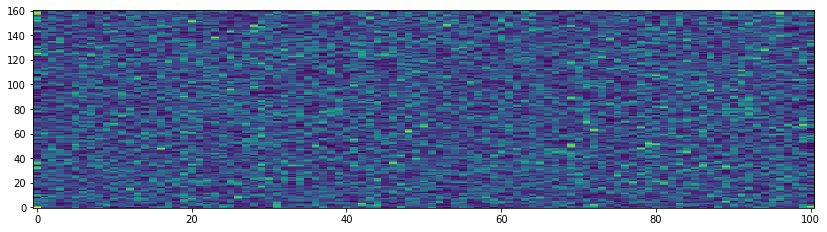

In [35]:
#this case is marked as unknown, so need to add white_noise.wav into the silence class
file="clip_e5248f48a.wav"
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.imshow(np.squeeze(get_spect(test_audio_path + file , add_noise=False), axis=0) , aspect='auto', origin='lower')
ipd.Audio(join(test_audio_path, file))